In [2]:
import hu_core_news_lg
import numpy
import pandas as pd
import spacy
import os

from nltk.corpus import stopwords
from tqdm import tqdm

In [3]:
try:
    nlp = spacy.load("hu_core_news_lg")
except:
    print("Can't found the big modell. Using the medium sized...")
    nlp = spacy.load("hu_core_news_md")

In [4]:
nlp = hu_core_news_lg.load()

# Loading the data

In [11]:
RAW_CSV = r"../../data/articles.csv"
PROCESSED_CSV = r"../../data/preprocessed_articles.csv"

In [12]:
csv_file = r"../../data/articles.csv"

df = pd.read_csv(csv_file, encoding="utf-8-sig")

In [15]:
df.sample()

,url,title,text,label
1156,https://mandiner.hu/belfold/2025/12/ennyit-arr...,"Ennyit arról, hogy előre megírt kérdéseket kap...",Ellenzéki kérdező is feltette a kérdéseit Orbá...,1


In [16]:
df.label.value_counts()

label
0    756
1    566
Name: count, dtype: int64

# Preprocessing

In [7]:
def spacy_preprocess_pipe(texts, batch_size=50):
    cleaned_texts = []
    
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, disable=["ner", "parser"]), 
                    total=len(texts), 
                    desc="Preprocessing the text"):
        
        tokens = []
        for token in doc:
            if token.is_stop or token.is_punct:
                continue
            if token.like_num:
                tokens.append("NUM")
            else:
                tokens.append(token.lemma_)
        
        cleaned_texts.append(" ".join(tokens))
    
    return cleaned_texts

In [8]:
def get_training_data():
    # 1. Loading the raw data
    if not os.path.exists(RAW_CSV):
        raise FileNotFoundError(f"No sourcefile: {RAW_CSV}")
        
    df_raw = pd.read_csv(RAW_CSV, encoding="utf-8-sig")
    df_raw = df_raw.dropna(subset=['title', 'text', 'url'])
    
    # 2. Check if there's a saved file
    if os.path.exists(PROCESSED_CSV):
        df_processed = pd.read_csv(PROCESSED_CSV, encoding="utf-8-sig")
        processed_urls = set(df_processed['url'])
        print(f"Loaded {len(df_processed)} preprocessed articles.")
    else:
        df_processed = pd.DataFrame(columns=['url', 'cleaned_text', 'label'])
        processed_urls = set()
        print("There's no preprocessed articles.")

    # 3. Filter out
    df_new = df_raw[~df_raw['url'].isin(processed_urls)].copy()

    if df_new.empty:
        print("There's no preprocessed articles. Working from the cache")
    else:
        print(f"Under preprocessing: {len(df_new)} new articles...")
        
        df_new['full_text'] = df_new['title'] + ": " + df_new['text']
        
        df_new['cleaned_text'] = spacy_preprocess_pipe(df_new['full_text'].tolist())
        
        # 4. Save
        df_to_save = df_new[['url', 'cleaned_text', 'label']]
        header_needed = not os.path.exists(PROCESSED_CSV)
        
        df_to_save.to_csv(PROCESSED_CSV, mode='a', index=False, header=header_needed, encoding='utf-8-sig')
        
        df_processed = pd.concat([df_processed, df_to_save], ignore_index=True)
        print("New datas saved.")

    return df_processed['cleaned_text'], df_processed['label']

In [9]:
def spacy_preprocess_one(text):
    """
    Preprocessing a single string
    """
    doc = nlp(text, disable=["ner", "parser"])
    
    clean_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        if token.like_num:
            clean_tokens.append("NUM")
        else:
            clean_tokens.append(token.lemma_)
    
    return " ".join(clean_tokens)

In [42]:
x, y = get_training_data()
y = y.astype(int)
x.sample()

Loaded 1706 preprocessed articles.
There's no preprocessed articles. Working from the cache


1295    halhatatlanság megszállott Agyagkatona Szépműv...
Name: cleaned_text, dtype: object

In [21]:
y.value_counts()

label
0    867
1    839
Name: count, dtype: int64

# CountVectorizer

In [14]:
hu_stop_words = [
    "2010", "2020", "a", "abban", "ad", "adatvédelmi", "ahhoz", "ahogy", 
    "ahol", "ahogy", "aki", "akik", "akit", "akár", "akkor", "alá", "alatt", "által", 
    "általában", "amely", "amelyek", "amelyekben", "amelyeket", "amelyet", "amelynek", 
    "ami", "amíg", "amikor", "amit", "amolyan", "amúgy", "annak", "arra", "arról", 
    "át", "az", "azért", "azok", "azoknak", "azon", "azonban", "azt", "aztán", 
    "azután", "azzal", "ászf", "bár", "be", "bele", "belül", "benne", "cikk", 
    "cikkek", "cikkeket", "com", "copyright", "csak", "de", "e", "ebben", "eddig", 
    "egész", "egy", "egyéb", "egyes", "egyetlen", "egyik", "egyre", "ehhez", "ekkor", 
    "el", "elég", "ellen", "elő", "először", "előtt", "első", "ember", "emilyen", 
    "én", "ennek", "éppen", "erre", "es", "esetleg", "és", "evvel", "ez", "ezek", 
    "ezen", "ezért", "ezt", "ezzel", "fel", "feladva", "felé", "felett", "fel", 
    "főleg", "ha", "hanem", "hát", "hello", "helló", "helyett", "hirtelen", 
    "hiszen", "hogy", "hogyan", "hol", "hozzászólás", "hozzászólások", "http", 
    "ide", "igen", "így", "igy", "ill", "ill.", "illetve", "ilyen", "ilyenkor", 
    "impresszum", "is", "ismét", "ison", "itt", "jó", "jobban", "jog fenntartva", 
    "jogi nyilatkozat", "jól", "kategória", "kell", "kellett", "keressünk", 
    "keresztül", "ki", "kis", "kívül", "komment", "köszönöm", "köszönjük", "köszi", 
    "közepette", "között", "közül", "külön", "le", "legalább", "legyen", "lehet", 
    "lehetett", "lenne", "lenni", "lesz", "lett", "maga", "magam", "magatokat", 
    "magát", "magunk", "magunkat", "magunkkal", "magunkra", "majd", "már", "más", 
    "másik", "meg", "még", "mellett", "mely", "melyek", "mert", "mi", "miért", 
    "míg", "mikor", "milyen", "mind", "minden", "mindenki", "mindenkinek", 
    "mindenkit", "mindent", "mindig", "mindneki", "mint", "mintha", "mit", 
    "mivel", "most", "nagy", "nagyobb", "nagyon", "ne", "néha", "néhány", 
    "nekem", "neki", "nélkül", "nem", "nincs", "ő", "oda", "ők", "õk", "őket", 
    "oka", "olyan", "ön", "os", "össze", "ott", "pedig", "persze", "pici", 
    "picivel", "pont", "rá", "rám", "rajtam", "ripost", "rólam", "rólunk", "rss", 
    "s", "saját", "sajnos", "sem", "semmi", "soha", "sok", "sokat", "sokkal", 
    "száma", "számára", "szemben", "szerint", "szerintem", "szeretettel", 
    "szerző", "szét", "szia", "sziasztok", "szinte", "szó", "talán", "te", 
    "tehát", "teljes", "ti", "több", "tőle", "tőlem", "tőletek", "tőlük", 
    "tőlünk", "tovább", "továbbá", "üdv", "úgy", "ugyanis", "új", "újabb", 
    "újra", "után", "utána", "utolsó", "vagy", "vagyis", "vagyok", "valaki", 
    "valami", "valamint", "valamit", "valaminek", "valamiért", "való", "van", 
    "vannak", "vele", "velem", "veletek", "velük", "vissza", "viszont", "volna", 
    "volt", "voltak", "voltam", "voltunk", "www"
]

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [43]:
vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1, max_df=0.9, max_features=2000, stop_words=hu_stop_words)
x_counts = vectorizer.fit_transform(x)

C:\Users\leven\PycharmProjects\propaganda\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fenntartva', 'jog', 'jogi', 'nyilatkozat'] not in stop_words.
  warnings.warn(


# Tfidf

In [44]:
tfidf = TfidfTransformer(sublinear_tf=True)
x_tfidf = tfidf.fit_transform(x_counts)

In [26]:
x_tfidf.shape

(1706, 2000)

## Getting the most frequent words by category

In [18]:
def get_tfidf_scores(series):
    vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1, max_df=0.9, max_features=2000, stop_words=hu_stop_words.append('num'))
    x_counts_s = vectorizer.fit_transform(series)
    feature_names_s = vectorizer.get_feature_names_out()
    
    tfidf = TfidfTransformer(sublinear_tf=True)
    x_tfidf_s = tfidf.fit_transform(x_counts_s)
    
    mean_tfidf_s = x_tfidf_s.mean(axis=0)
    tfidf_scores = [(feature_names_s[i], mean_tfidf_s[0, i]) for i in range(len(feature_names_s))]
    tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    
    df_tfidf_top = pd.DataFrame(tfidf_scores, columns=['Word', 'Mean TFIDF'])
    return df_tfidf_top

In [78]:
x0 = x[y == 0]
x1 = x[y == 1]

x0_tfidf = get_tfidf_scores(x0)
x1_tfidf = get_tfidf_scores(x1)

In [94]:
x0_tfidf.head(100)

,Word,Mean TFIDF
0,num,0.048175
1,magyar,0.033808
2,év,0.029241
3,tud,0.025201
4,ír,0.023863
...,...,...
95,kapcsolat,0.012343
96,elmúlt,0.012337
97,lehetőség,0.012315
98,munka,0.012299


In [95]:
x1_tfidf.head(100)

,Word,Mean TFIDF
0,num,0.044941
1,magyar,0.037042
2,tisza,0.032479
3,orbán,0.026549
4,párt,0.025476
...,...,...
95,hozzátesz,0.010535
96,num éves,0.010523
97,ami,0.010433
98,maga,0.010403


In [106]:
words = ['trump', 'putyin', 'eu']

for i in words:
    # Megkeressük a szót mindkét TF-IDF listában
    val_0 = x0_tfidf[x0_tfidf["Word"] == i]
    val_1 = x1_tfidf[x1_tfidf["Word"] == i]
    
    # Kiíratás (ha nem található a szó, jelezzük)
    score_0 = val_0["Mean TFIDF"].values[0] if not val_0.empty else "N/A"
    score_1 = val_1["Mean TFIDF"].values[0] if not val_1.empty else "N/A"
    
    print(f"Szó: {i} | Independent: {score_0} | Pro-Gov: {score_1}")

Szó: trump | Independent: 0.0128064264616125 | Pro-Gov: 0.009267675700448109
Szó: putyin | Independent: 0.005599862219723586 | Pro-Gov: 0.006655505708563857
Szó: eu | Independent: 0.01109240931860779 | Pro-Gov: 0.009871136421883043


In [27]:
feature_names = vectorizer.get_feature_names_out()

sum_words = x_counts.sum(axis=0) 

words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

df_freq = pd.DataFrame(words_freq, columns=['Word', 'Frequency'])

print("Top 15 most frequent words:")
display(df_freq.head(15))

Top 10 most frequent words:


,Word,Frequency
0,num,8970
1,magyar,4025
2,év,2227
3,tisza,1941
4,tud,1881
5,orbán,1712
6,párt,1417
7,tesz,1384
8,péter,1275
9,ír,1262


# Train, valid, test

In [45]:
from sklearn.model_selection import train_test_split

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_tfidf, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)
print(f"Learning+Validating dataset size: {x_train_full.shape[0]}")
print(f"Test dataset size: {x_test.shape[0]}") 

Learning+Validating dataset size: 1450
Test dataset size: 256


In [46]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [47]:
fold = 1
for train_index, val_index in skf.split(x_train_full, y_train_full):
    x_train, x_valid = x_train_full[train_index], x_train_full[val_index]
    y_train, y_valid = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    
    print(f"\n--- {fold}. FOLD ---")
    print(f"Learning (x_train): {x_train.shape[0]} db")
    print(f"Validation (x_valid): {x_valid.shape[0]} db")
    print(f"Test (x_test): {x_test.shape[0]} db (fix)")
    
    fold += 1


--- 1. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)

--- 2. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)

--- 3. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)

--- 4. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)

--- 5. FOLD ---
Learning (x_train): 1160 db
Validation (x_valid): 290 db
Test (x_test): 256 db (fix)


# Baseline

In [35]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
import numpy as np

classifier = DummyClassifier(strategy='most_frequent')
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

print(classification_report(y_test, y_pred, zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       130
           1        nan      0.00      0.00       126

    accuracy                           0.51       256
   macro avg       0.51      0.50      0.34       256
weighted avg       0.51      0.51      0.34       256



# LinearSVC

In [31]:
from sklearn.svm import LinearSVC, SVC

svc = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=5000
)
svc.fit(x_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [32]:
from sklearn.metrics._classification import classification_report
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       130
           1       0.78      0.74      0.76       126

    accuracy                           0.77       256
   macro avg       0.77      0.77      0.77       256
weighted avg       0.77      0.77      0.77       256



# Finetuning

In [33]:
from sklearn.metrics import f1_score, classification_report

valid_f1 = []
train_f1 = []
C_values = []

for l in range(-7, 5):
    C = 10**l
    C_values.append(C)
    
    # LinearSVC 
    lin = LinearSVC(
        random_state=42,
        max_iter=20000,
        class_weight="balanced",
        C=C,
        dual="auto" 
    )
    
    lin.fit(x_train, y_train)
    
    # Prediction
    valid_pred = lin.predict(x_valid)
    train_pred = lin.predict(x_train)
    
    # Save the score
    valid_f1.append(f1_score(y_valid, valid_pred, pos_label=1))
    train_f1.append(f1_score(y_train, train_pred, pos_label=1))

    print(f"C={C:.1e} finished.")

C=1.0e-07 finished.
C=1.0e-06 finished.
C=1.0e-05 finished.
C=1.0e-04 finished.
C=1.0e-03 finished.
C=1.0e-02 finished.
C=1.0e-01 finished.
C=1.0e+00 finished.
C=1.0e+01 finished.
C=1.0e+02 finished.
C=1.0e+03 finished.
C=1.0e+04 finished.


C:\Users\leven\PycharmProjects\propaganda\.venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


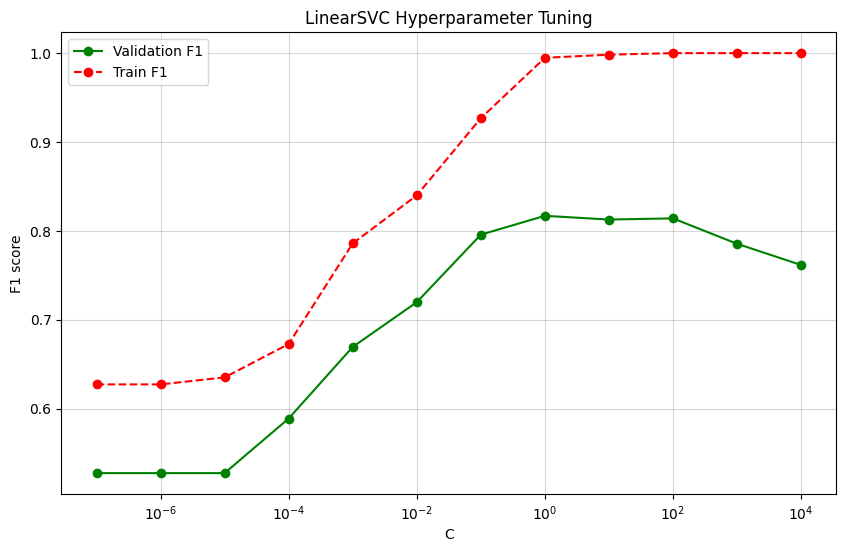

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(C_values, valid_f1, label="Validation F1", marker="o", color="green")
plt.plot(C_values, train_f1, label="Train F1", marker="o", color="red", linestyle="--")

plt.xscale("log")  # EZ TÖKÉLETES ÍGY!
plt.xlabel("C")
plt.ylabel("F1 score")
plt.title("LinearSVC Hyperparameter Tuning")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

In [35]:
svc = LinearSVC(random_state=0,
                           max_iter=20000,
                           class_weight="balanced",
                           C=10**(0),
                           dual="auto")
svc.fit(x_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo 

In [36]:
y_pred = svc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       130
           1       0.78      0.74      0.76       126

    accuracy                           0.77       256
   macro avg       0.77      0.77      0.77       256
weighted avg       0.77      0.77      0.77       256



In [37]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(svc, method='sigmoid', cv=5)
calibrated_svc.fit(x_train, y_train)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",LinearSVC(C=1...andom_state=0)
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or 

# GradientBoostingClassifier

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    min_samples_leaf=5,
    random_state=42
)

# Ensemble

In [39]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[('svc', calibrated_svc), ('gb', gb_model)],
    voting='hard'
)
ensemble_model.fit(x_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('svc', ...), ('gb', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1


In [40]:
from sklearn.metrics import accuracy_score

y_pred = ensemble_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification repot:\n", classification_report(y_test, y_pred))

Accuracy: 0.79296875
Classification repot:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81       130
           1       0.86      0.69      0.77       126

    accuracy                           0.79       256
   macro avg       0.80      0.79      0.79       256
weighted avg       0.80      0.79      0.79       256



# Grid Search

In [86]:
import numpy as np
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import GradientBoostingClassifier
from scipy.sparse import vstack as sparse_vstack

X_combined = sparse_vstack([x_train, x_valid])

y_combined = np.concatenate([y_train, y_valid])

print(f"X_combined alakja: {X_combined.shape}")
print(f"y_combined hossza: {len(y_combined)}")

test_fold = np.zeros(X_combined.shape[0])
test_fold[:x_train.shape[0]] = -1
test_fold[x_train.shape[0]:] = 0

ps = PredefinedSplit(test_fold)

X_combined alakja: (1450, 2000)
y_combined hossza: 1450


In [87]:
from sklearn.model_selection import RandomizedSearchCV

gb_base = GradientBoostingClassifier(random_state=42)
ensemble_grid = VotingClassifier(
    estimators=[('svc', calibrated_svc), ('gb', gb_model)]
)

param_grid = {
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3, 4, 5],
    'gb__subsample': [0.7, 0.8, 1.0],
    'gb__min_samples_leaf': [3, 5, 7],

    'weights': [
        [1, 1], 
        [2, 1],
        [3, 1],
        [3, 2]
    ]
}


random_search = RandomizedSearchCV(
    estimator=ensemble_grid, 
    param_distributions=param_grid,
    n_iter=50,                     
    cv=ps, 
    scoring='accuracy', 
    verbose=2, 
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_combined, y_combined)

print(f"Best features: {random_search.best_params_}")
print(f"Best accuracy on the validational dataset: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_
y_pred_f = final_model.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_f))

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Best features: {'weights': [1, 1], 'gb__subsample': 0.7, 'gb__n_estimators': 200, 'gb__min_samples_leaf': 5, 'gb__max_depth': 3, 'gb__learning_rate': 0.1}
Best accuracy on the validational dataset: 0.8241
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       130
           1       0.88      0.69      0.77       126

    accuracy                           0.80       256
   macro avg       0.82      0.80      0.80       256
weighted avg       0.81      0.80      0.80       256



In [88]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.7,
    min_samples_leaf=3,
    random_state=42
)

In [89]:
# gb = GradientBoostingClassifier(
#     max_depth=4,
#     min_samples_leaf=3,
#     n_estimators=200,
#     random_state=42,
#     subsample=0.7
# )
# svc = LinearSVC(C=1, max_iter=20000, class_weight='balanced', random_state=0)
# gb.fit(x_train, y_train)
# svc.fit(x_train, y_train)

In [90]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[('svc', calibrated_svc), ('gb', gb_model)],
    voting='soft'
)
ensemble_model.fit(x_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('svc', ...), ('gb', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1


In [91]:
from sklearn.metrics import accuracy_score
y_pred = ensemble_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.79296875
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80       130
           1       0.81      0.75      0.78       126

    accuracy                           0.79       256
   macro avg       0.79      0.79      0.79       256
weighted avg       0.79      0.79      0.79       256



# Saving the modell

In [92]:
from joblib import dump, load
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('count', vectorizer),
    ('tfidf', tfidf),
    ('clf', ensemble_model)
])
pipeline.fit(x, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('count', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [93]:
dump(pipeline, '../../models/ensemble_pipeline.joblib')

['../../models/ensemble_pipeline.joblib']